<a href="https://colab.research.google.com/github/rabnawaz172/Diabetic-Retinopathy/blob/main/voice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import librosa
import pandas as pd
from sklearn.utils import shuffle

# Assuming the Google Drive dataset folder is loaded to a local directory using Google Colab
# Mount Google Drive first to access the files

from google.colab import drive
drive.mount('/content/drive')


MessageError: Error: credential propagation was unsuccessful

Processing 119 files in class 'NORM'
Processing 127 files in class 'PATHOL'
Evaluating DT...
Evaluating RF...
Evaluating SVM...
Evaluating NB...


<ipython-input-21-0725bc0c2770>:117: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Classifier', y='Accuracy', data=df_metrics, ax=axes[0, 0], palette=palette)
<ipython-input-21-0725bc0c2770>:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Classifier', y='Precision', data=df_metrics, ax=axes[0, 1], palette=palette)
<ipython-input-21-0725bc0c2770>:131: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Classifier', y='Recall', data=df_metrics, ax=axes[1, 0], palette=palette)
<ipython-input-21-0725bc0c2770>:138: FutureWarning: 

Passing 

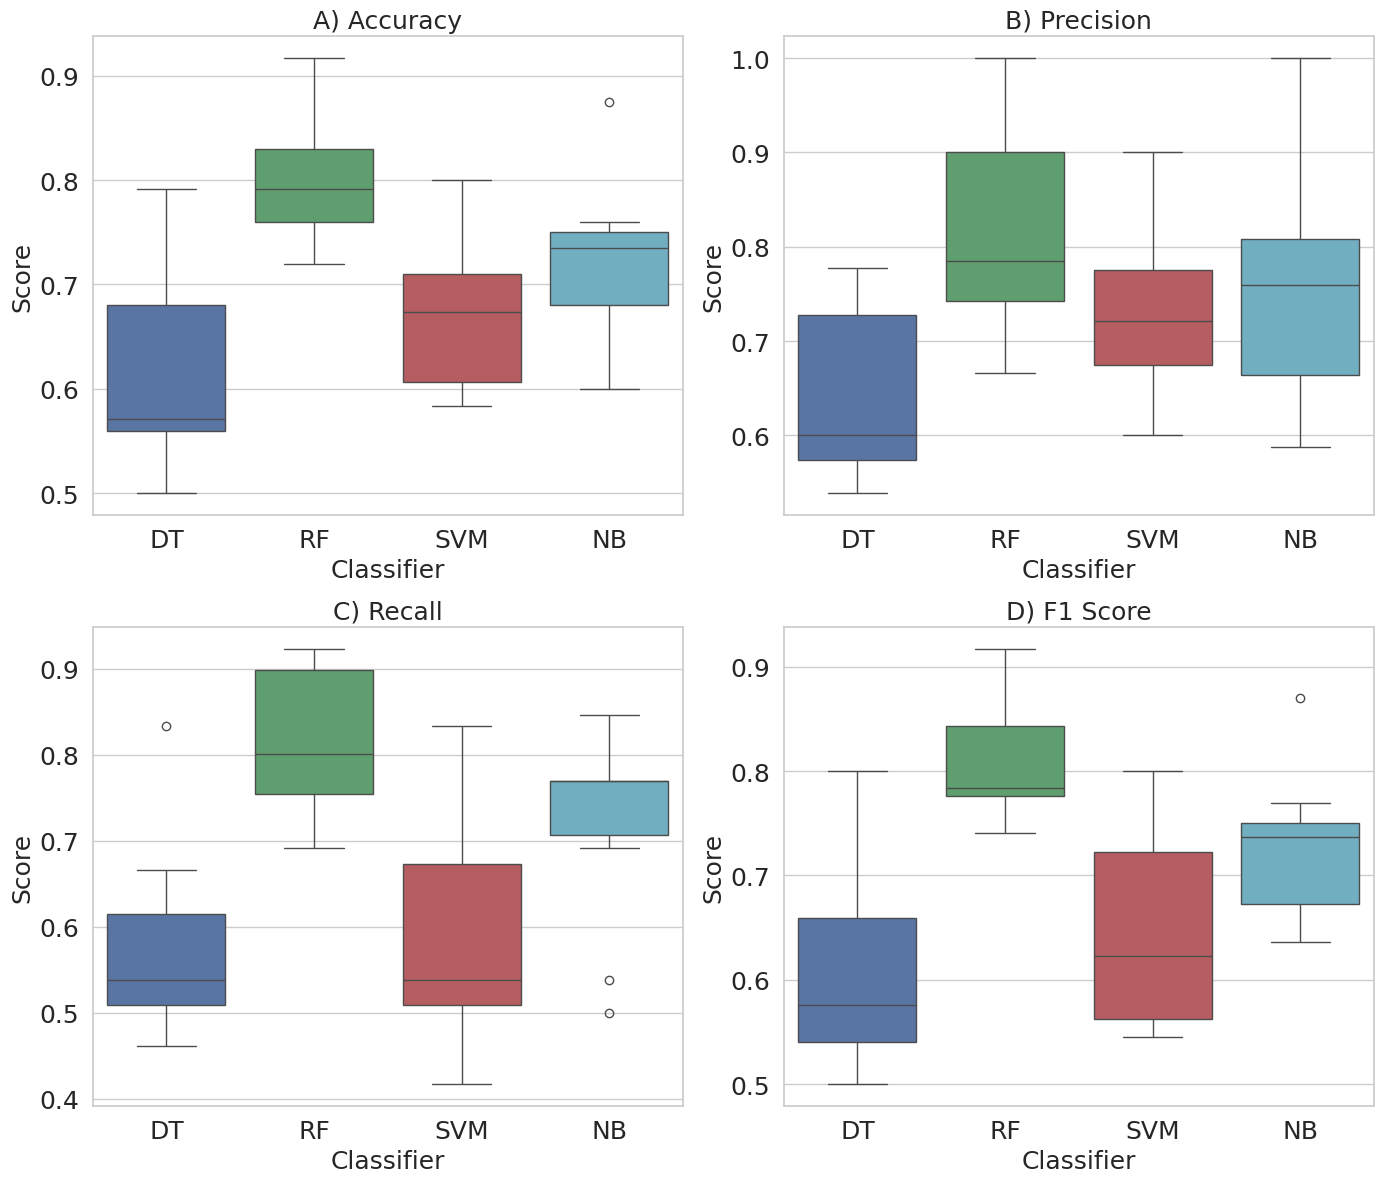

In [ ]:
import os
import numpy as np
import librosa
import seaborn as sns
import pandas as pd
from sklearn.utils import shuffle
import glob
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Set seaborn style with grid
sns.set(style="whitegrid")

# Set base path and class labels
base_path = '/content/drive/MyDrive/Voice Pathology/'  # Update this path if different
classes = ['NORM', 'PATHOL']
labels = {'NORM': 0, 'PATHOL': 1}

def extract_features(file_path, n_mfcc=13, max_len=130):
    try:
        y, sr = librosa.load(file_path, sr=None)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        mfccs_delta = librosa.feature.delta(mfccs)
        mfccs_delta2 = librosa.feature.delta(mfccs, order=2)
        feature_vector = np.hstack((mfccs, mfccs_delta, mfccs_delta2))
        if feature_vector.shape[1] < max_len:
            pad_width = max_len - feature_vector.shape[1]
            feature_vector = np.pad(feature_vector, ((0, 0), (0, pad_width)), mode='constant')
        elif feature_vector.shape[1] > max_len:
            feature_vector = feature_vector[:, :max_len]
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        feature_vector = np.zeros((n_mfcc * 3, max_len))
    return feature_vector

features = []
target = []
max_len = 130

for class_name in classes:
    class_path = os.path.join(base_path, class_name, '*.wav')
    file_list = glob.glob(class_path)

    print(f"Processing {len(file_list)} files in class '{class_name}'")

    for file in file_list:
        feature_vector = extract_features(file, max_len=max_len)
        features.append(feature_vector)
        target.append(labels[class_name])

X = np.array(features)
Y = np.array(target)
n_samples, n_channels, n_frames = X.shape
X_flat = X.reshape(n_samples, -1)
X_flat, Y = shuffle(X_flat, Y, random_state=42)

classifiers = {
    'DT': DecisionTreeClassifier(random_state=42),
    'RF': RandomForestClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'NB': GaussianNB()
}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

metrics = {
    'Classifier': [],
    'Fold': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': []
}

for name, clf in classifiers.items():
    print(f"Evaluating {name}...")
    for fold, (train_index, test_index) in enumerate(cv.split(X_flat, Y)):
        X_train, X_test = X_flat[train_index], X_flat[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]

        clf.fit(X_train, Y_train)
        y_pred = clf.predict(X_test)

        accuracy = accuracy_score(Y_test, y_pred)
        precision = precision_score(Y_test, y_pred)
        recall = recall_score(Y_test, y_pred)
        f1 = f1_score(Y_test, y_pred)

        metrics['Classifier'].append(name)
        metrics['Fold'].append(fold + 1)
        metrics['Accuracy'].append(accuracy)
        metrics['Precision'].append(precision)
        metrics['Recall'].append(recall)
        metrics['F1 Score'].append(f1)

# Convert metrics dictionary to DataFrame for easier plotting
df_metrics = pd.DataFrame(metrics)

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
subplot_titles = ['A) Accuracy', 'B) Precision', 'C) Recall', 'D) F1 Score']

# Boxplot colors for each classifier
palette = {
    'DT': 'b',
    'RF': 'g',
    'SVM': 'r',
    'NB': 'c'
}

# Plot Accuracy
sns.boxplot(x='Classifier', y='Accuracy', data=df_metrics, ax=axes[0, 0], palette=palette)
axes[0, 0].set_title(subplot_titles[0], fontsize=18)
axes[0, 0].set_xlabel('Classifier', fontsize=18)
axes[0, 0].set_ylabel('Score', fontsize=18)
axes[0, 0].tick_params(axis='both', labelsize=18)

# Plot Precision
sns.boxplot(x='Classifier', y='Precision', data=df_metrics, ax=axes[0, 1], palette=palette)
axes[0, 1].set_title(subplot_titles[1], fontsize=18)
axes[0, 1].set_xlabel('Classifier', fontsize=18)
axes[0, 1].set_ylabel('Score', fontsize=18)
axes[0, 1].tick_params(axis='both', labelsize=18)

# Plot Recall
sns.boxplot(x='Classifier', y='Recall', data=df_metrics, ax=axes[1, 0], palette=palette)
axes[1, 0].set_title(subplot_titles[2], fontsize=18)
axes[1, 0].set_xlabel('Classifier', fontsize=18)
axes[1, 0].set_ylabel('Score', fontsize=18)
axes[1, 0].tick_params(axis='both', labelsize=18)

# Plot F1 Score
sns.boxplot(x='Classifier', y='F1 Score', data=df_metrics, ax=axes[1, 1], palette=palette)
axes[1, 1].set_title(subplot_titles[3], fontsize=18)
axes[1, 1].set_xlabel('Classifier', fontsize=18)
axes[1, 1].set_ylabel('Score', fontsize=18)
axes[1, 1].tick_params(axis='both', labelsize=18)

# Adjust layout for better display
plt.tight_layout()
plt.show()


Evaluating DT...
Evaluating RF...
Evaluating SVM...
Evaluating NB...


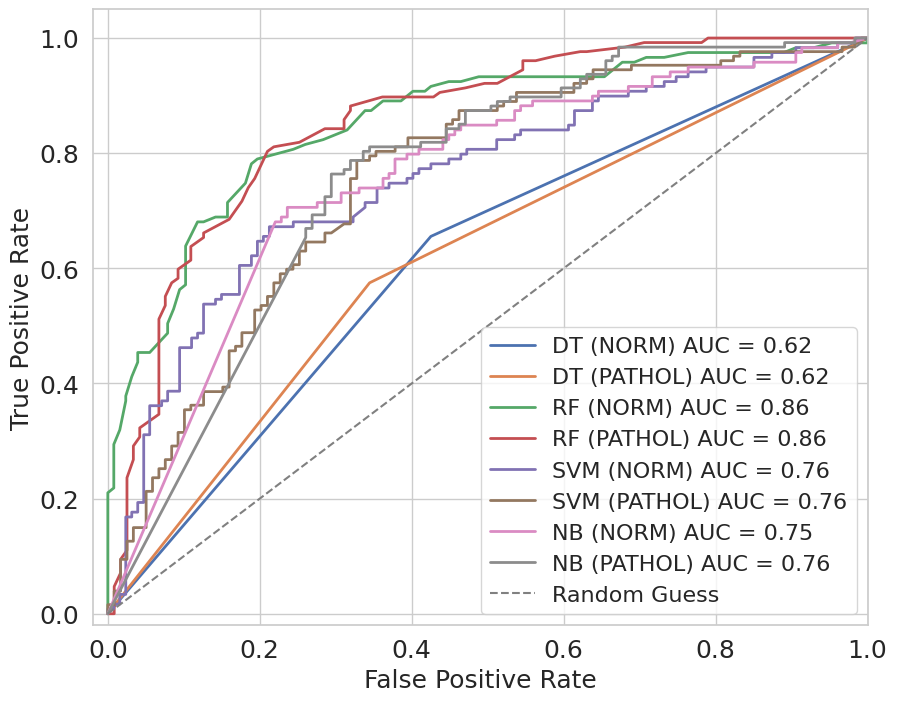

In [ ]:

import os
import numpy as np
import librosa
import seaborn as sns
import pandas as pd
from sklearn.utils import shuffle
import glob
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold, cross_val_predict # Import cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc # Import roc_curve and auc
import matplotlib.pyplot as plt
# Plot ROC curves for each classifier
plt.figure(figsize=(10, 8))

for name, clf in classifiers.items():
    print(f"Evaluating {name}...")

    # Cross-validation predictions (probabilities)
    probas_ = cross_val_predict(clf, X_flat, Y, cv=cv, method="predict_proba")

    # Calculate ROC curve and AUC for both classes
    fpr_0, tpr_0, _ = roc_curve(Y, probas_[:, 0], pos_label=0)  # For class NORM (label 0)
    fpr_1, tpr_1, _ = roc_curve(Y, probas_[:, 1], pos_label=1)  # For class PATHOL (label 1)

    auc_0 = auc(fpr_0, tpr_0)
    auc_1 = auc(fpr_1, tpr_1)

    # Plot the ROC curve for both classes
    plt.plot(fpr_0, tpr_0, lw=2, label=f'{name} (NORM) AUC = {auc_0:.2f}')
    plt.plot(fpr_1, tpr_1, lw=2, label=f'{name} (PATHOL) AUC = {auc_1:.2f}')

# Plot the diagonal line representing random guessing
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')

# Formatting the plot
plt.xlim([-0.02, 1.0])
plt.ylim([-0.02, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)


# Set tick labels font size
plt.tick_params(axis='both', which='major', labelsize=18)
plt.grid(True)
# Display legend with font size 18
plt.legend(loc="lower right", fontsize=16)

# Show the plot
plt.show()


Evaluating DT...
DT Performance Metrics:
Accuracy: 0.61
Precision: 0.62
Recall: 0.61
F1 Score: 0.61
--------------------------------------------------
Evaluating RF...
RF Performance Metrics:
Accuracy: 0.80
Precision: 0.80
Recall: 0.80
F1 Score: 0.80
--------------------------------------------------
Evaluating SVM...
SVM Performance Metrics:
Accuracy: 0.67
Precision: 0.68
Recall: 0.67
F1 Score: 0.67
--------------------------------------------------
Evaluating NB...
NB Performance Metrics:
Accuracy: 0.72
Precision: 0.72
Recall: 0.72
F1 Score: 0.72
--------------------------------------------------


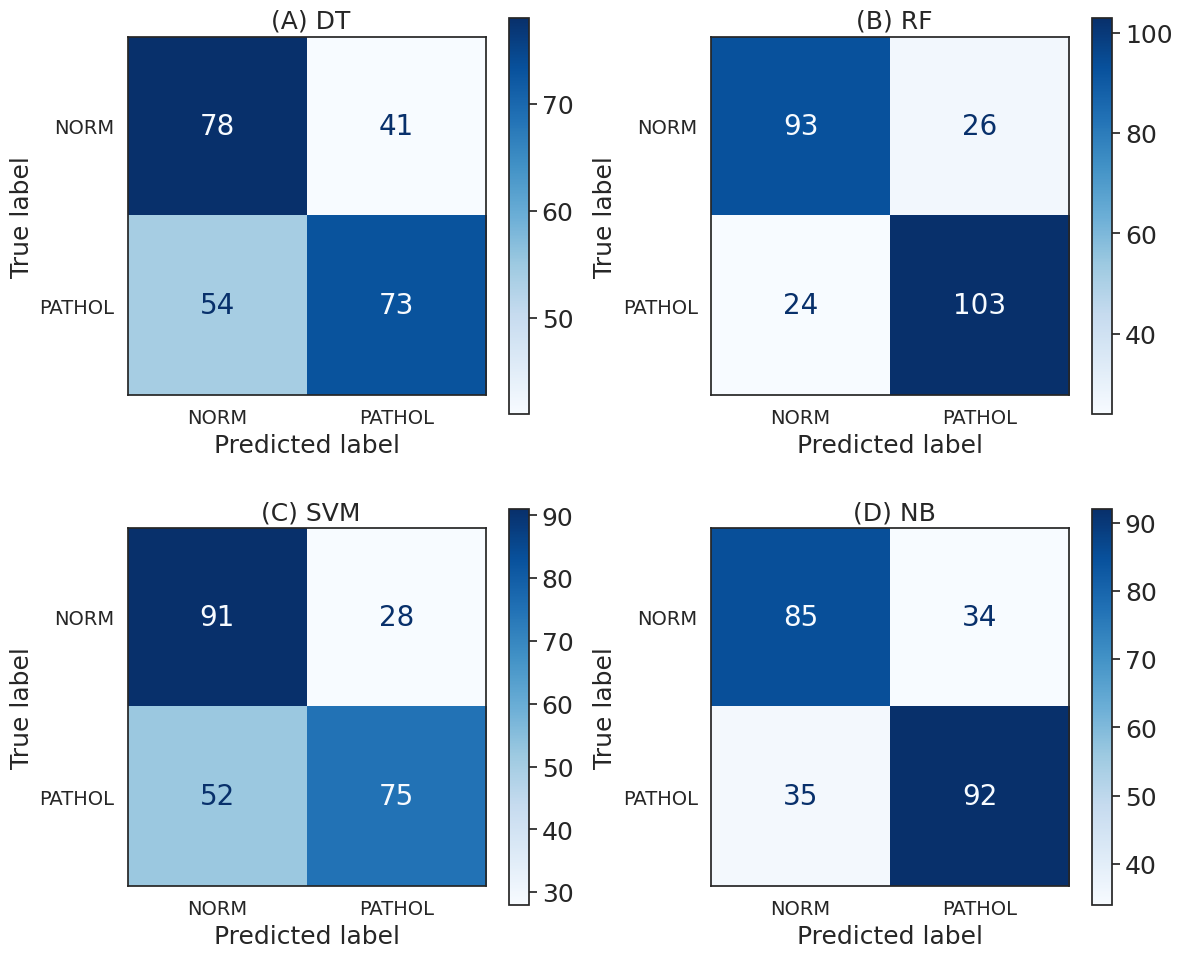

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import numpy as np
sns.set(style="white")


# Assuming you have your data in X_flat and Y, and cv (cross-validation) is defined
# Create a 2x2 grid of subplots for confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()  # Flatten the axes array to make it easier to iterate over

# Initialize index for the subplot grid
idx = 0
subplot_titles = ['A', 'B', 'C', 'D']

# Store performance metrics for radar plots
metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': []
}

# Color scheme for radar plots
colors = ['b', 'g', 'r', 'c']

# Iterate through classifiers and plot confusion matrices
for name, clf in classifiers.items():
    print(f"Evaluating {name}...")

    # Cross-validation predictions
    y_pred = cross_val_predict(clf, X_flat, Y, cv=cv)

    # Calculate confusion matrix
    cm = confusion_matrix(Y, y_pred)

    # Plot confusion matrix in the appropriate subplot
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(ax=axes[idx], cmap=plt.cm.Blues)

    # Set title, font size for labels, ticks, color bar, and annotations
    axes[idx].set_title(f" ({subplot_titles[idx]}) {name}", fontsize=18)
    axes[idx].tick_params(axis='both', labelsize=14)
    axes[idx].set_xlabel(axes[idx].get_xlabel(), fontsize=18)
    axes[idx].set_ylabel(axes[idx].get_ylabel(), fontsize=18)
    disp.im_.colorbar.ax.tick_params(labelsize=18)

    # Update the font size for annotations
    for labels in disp.text_.ravel():
        labels.set_fontsize(20)

    # Increment index for the next subplot
    idx += 1

    # Performance metrics
    accuracy = accuracy_score(Y, y_pred)
    precision = precision_score(Y, y_pred, average='weighted')
    recall = recall_score(Y, y_pred, average='weighted')
    f1 = f1_score(Y, y_pred, average='weighted')

    # Store metrics for radar plots
    metrics['accuracy'].append(accuracy)
    metrics['precision'].append(precision)
    metrics['recall'].append(recall)
    metrics['f1'].append(f1)

    print(f"{name} Performance Metrics:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print("-" * 50)

# Adjust layout for better display of confusion matrices
plt.tight_layout()
plt.show()



Evaluating DT...
DT Accuracy: 0.61
Evaluating RF...
RF Accuracy: 0.80
Evaluating SVM...
SVM Accuracy: 0.67
Evaluating NB...
NB Accuracy: 0.72


<ipython-input-24-ce37640ee915>:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{int(y*100)}%" for y in ax.get_yticks()], fontsize=18)


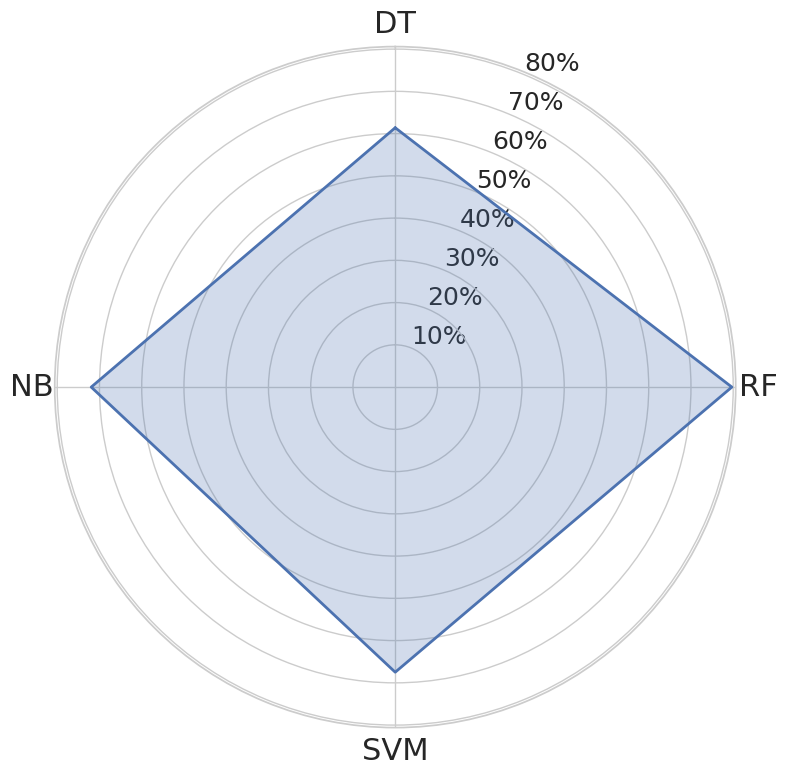

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")

# Assuming you have your data in X_flat and Y, and cv (cross-validation) is defined
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
title = "Accuracy"

# Store accuracy metrics
accuracy_metrics = []

classifiers = {
    'DT': DecisionTreeClassifier(random_state=42),
    'RF': RandomForestClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'NB': GaussianNB()
}

# Iterate through classifiers to compute accuracy
for name, clf in classifiers.items():
    print(f"Evaluating {name}...")

    # Cross-validation predictions
    y_pred = cross_val_predict(clf, X_flat, Y, cv=cv)

    # Accuracy
    accuracy = accuracy_score(Y, y_pred)

    # Store accuracy for radar plot
    accuracy_metrics.append(accuracy)

    print(f"{name} Accuracy: {accuracy:.2f}")

# Convert to DataFrame for easier plotting
df_accuracy = pd.DataFrame({
    'Classifier': classifiers.keys(),
    'Accuracy': accuracy_metrics
})

# Function to create radar plot
def create_radar_plot(ax, data, categories, title, color):
    N = len(categories)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]

    values = data.tolist()
    values += values[:1]

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.25)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=22)
    ax.set_yticklabels([f"{int(y*100)}%" for y in ax.get_yticks()], fontsize=18)

# Categories for radar plot
categories = classifiers.keys()
colors = 'b'  # Single color for accuracy plot

# Create radar plot
create_radar_plot(ax, df_accuracy['Accuracy'], categories, title, colors)

# Adjust layout for better display
plt.tight_layout()
plt.show()



Evaluating DT...
DT Performance Metrics:
Precision: 0.62
Recall: 0.61
F1 Score: 0.61
--------------------------------------------------
Evaluating RF...
RF Performance Metrics:
Precision: 0.80
Recall: 0.80
F1 Score: 0.80
--------------------------------------------------
Evaluating SVM...
SVM Performance Metrics:
Precision: 0.68
Recall: 0.67
F1 Score: 0.67
--------------------------------------------------
Evaluating NB...
NB Performance Metrics:
Precision: 0.72
Recall: 0.72
F1 Score: 0.72
--------------------------------------------------


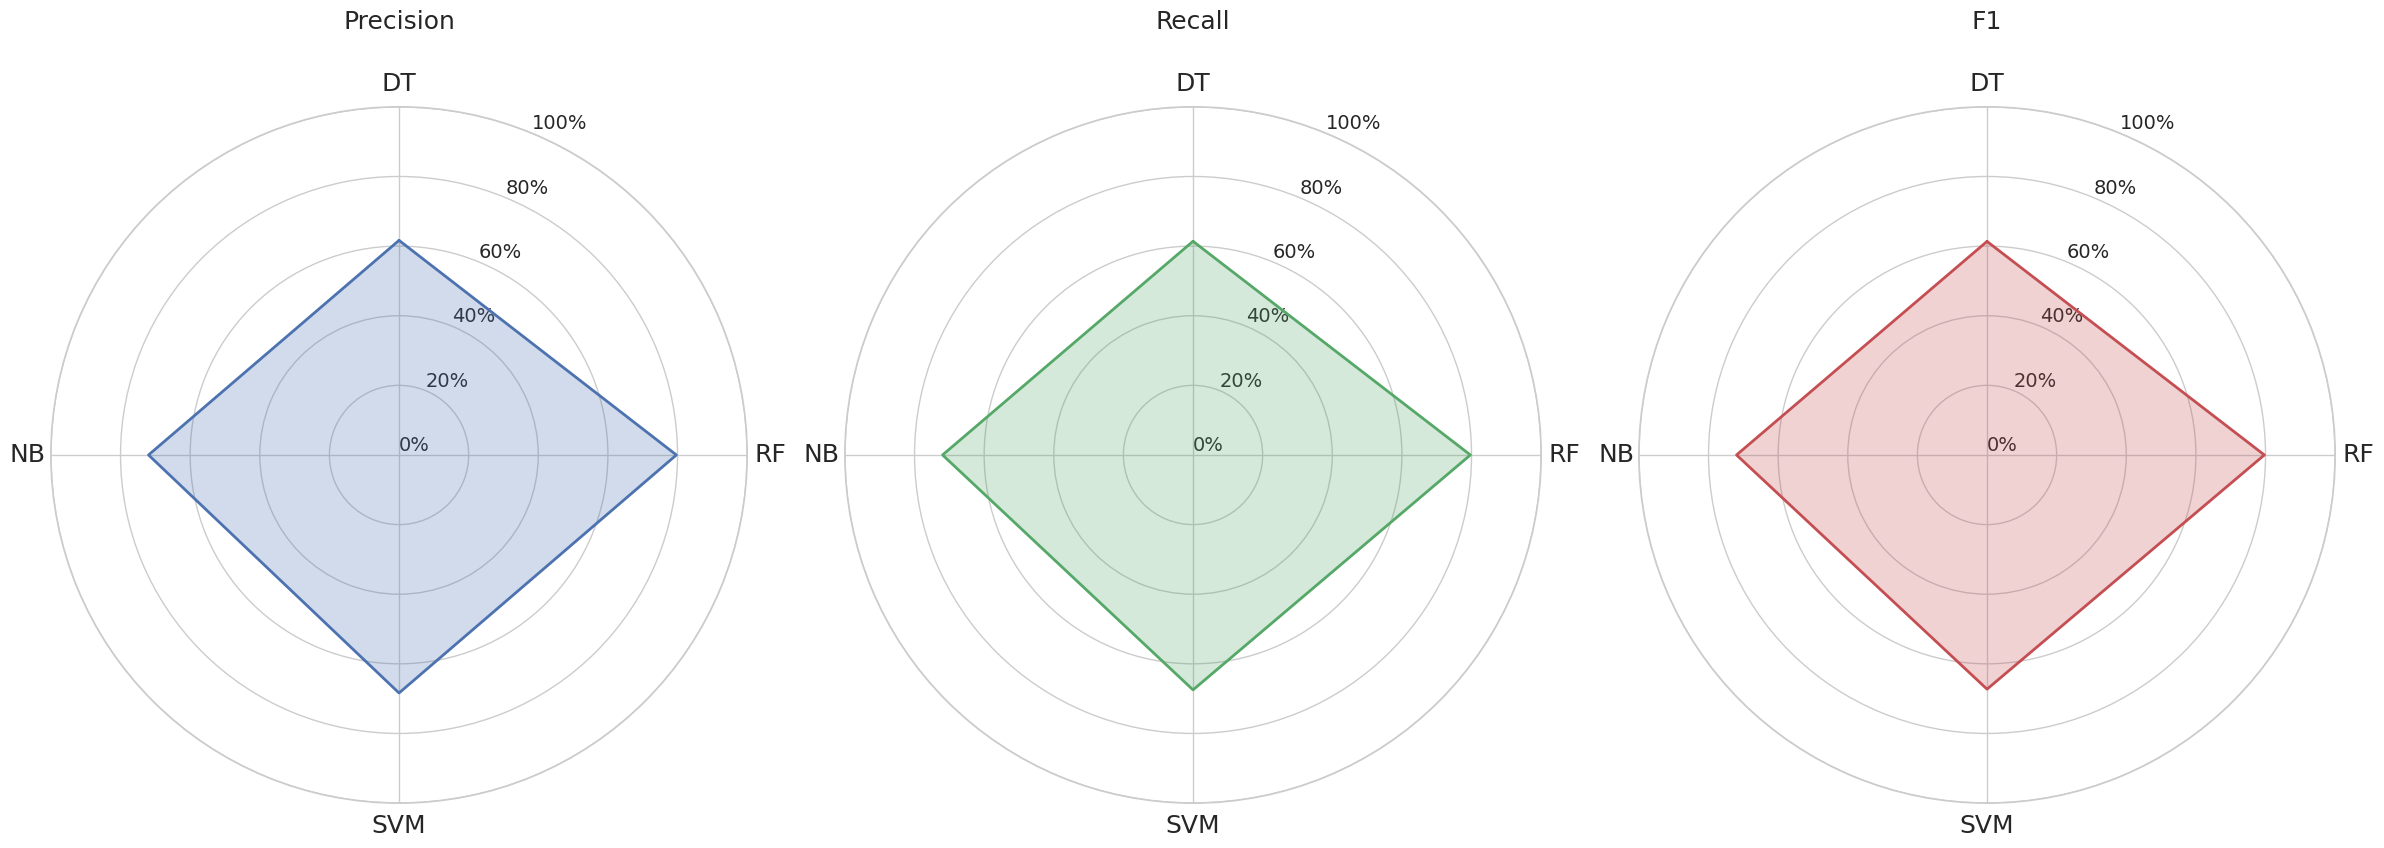

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")

# Assuming you have your data in X_flat and Y, and cv (cross-validation) is defined
# Initialize classifiers
classifiers = {
    'DT': DecisionTreeClassifier(random_state=42),
    'RF': RandomForestClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'NB': GaussianNB()
}

# Initialize StratifiedKFold
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Store performance metrics for radar plots
metrics = {
    'precision': [],
    'recall': [],
    'f1': []
}

# Collect performance metrics for each classifier
for name, clf in classifiers.items():
    print(f"Evaluating {name}...")

    # Cross-validation predictions
    y_pred = cross_val_predict(clf, X_flat, Y, cv=cv)

    # Performance metrics
    precision = precision_score(Y, y_pred, average='weighted')
    recall = recall_score(Y, y_pred, average='weighted')
    f1 = f1_score(Y, y_pred, average='weighted')

    # Store metrics for radar plots
    metrics['precision'].append(precision)
    metrics['recall'].append(recall)
    metrics['f1'].append(f1)

    print(f"{name} Performance Metrics:")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print("-" * 50)

# Convert metrics dictionary to DataFrame for easier plotting
df_metrics = pd.DataFrame(metrics, index=classifiers.keys())

# Function to create radar plot
def create_radar_plot(ax, data, categories, title, color):
    N = len(categories)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]

    values = data.tolist()
    values += values[:1]

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.25)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=18)
    ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels([f"{int(y*100)}%" for y in [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]], fontsize=14)
    ax.set_title(title, size=18, y=1.1)

# Categories for radar plots
categories = df_metrics.index
colors = ['b', 'g', 'r', 'c']

# Create subplots for radar charts
fig, axes = plt.subplots(1, 3, figsize=(24, 8), subplot_kw=dict(polar=True))

# Create radar plots
for metric, ax, color in zip(['precision', 'recall', 'f1'], axes.flatten(), colors):
    create_radar_plot(ax, df_metrics[metric], categories, metric.capitalize(), color)

# Adjust layout for better display
plt.tight_layout()
plt.show()


Evaluating DT...
DT Performance Metrics for NORM:
Precision: 0.59
Recall: 0.66
F1 Score: 0.62
--------------------------------------------------
DT Performance Metrics for PATH:
Precision: 0.64
Recall: 0.57
F1 Score: 0.61
--------------------------------------------------
Evaluating RF...
RF Performance Metrics for NORM:
Precision: 0.79
Recall: 0.78
F1 Score: 0.79
--------------------------------------------------
RF Performance Metrics for PATH:
Precision: 0.80
Recall: 0.81
F1 Score: 0.80
--------------------------------------------------
Evaluating SVM...
SVM Performance Metrics for NORM:
Precision: 0.64
Recall: 0.76
F1 Score: 0.69
--------------------------------------------------
SVM Performance Metrics for PATH:
Precision: 0.73
Recall: 0.59
F1 Score: 0.65
--------------------------------------------------
Evaluating NB...
NB Performance Metrics for NORM:
Precision: 0.71
Recall: 0.71
F1 Score: 0.71
--------------------------------------------------
NB Performance Metrics for PATH:


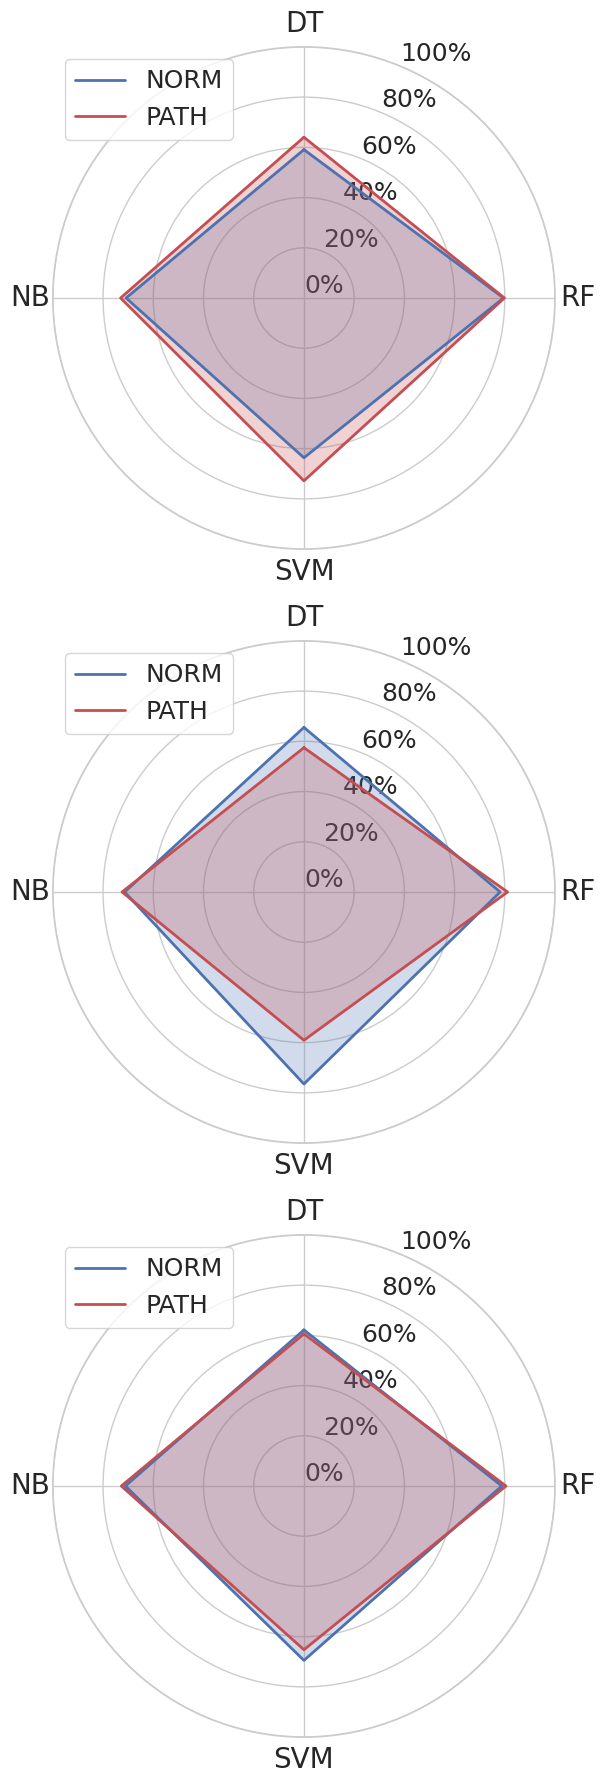

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")

# Assuming you have your data in X_flat and Y, and cv (cross-validation) is defined
# Initialize classifiers
classifiers = {
    'DT': DecisionTreeClassifier(random_state=42),
    'RF': RandomForestClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'NB': GaussianNB()
}

# Initialize StratifiedKFold
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Store performance metrics for radar plots
metrics = {
    'precision_NORM': [],
    'recall_NORM': [],
    'f1_NORM': [],
    'precision_PATH': [],
    'recall_PATH': [],
    'f1_PATH': []
}

# Collect performance metrics for each classifier
for name, clf in classifiers.items():
    print(f"Evaluating {name}...")

    # Cross-validation predictions
    y_pred = cross_val_predict(clf, X_flat, Y, cv=cv)

    # Performance metrics for each class
    precision_NORM = precision_score(Y, y_pred, pos_label=0, average='binary')
    recall_NORM = recall_score(Y, y_pred, pos_label=0, average='binary')
    f1_NORM = f1_score(Y, y_pred, pos_label=0, average='binary')

    precision_PATH = precision_score(Y, y_pred, pos_label=1, average='binary')
    recall_PATH = recall_score(Y, y_pred, pos_label=1, average='binary')
    f1_PATH = f1_score(Y, y_pred, pos_label=1, average='binary')

    # Store metrics for radar plots
    metrics['precision_NORM'].append(precision_NORM)
    metrics['recall_NORM'].append(recall_NORM)
    metrics['f1_NORM'].append(f1_NORM)

    metrics['precision_PATH'].append(precision_PATH)
    metrics['recall_PATH'].append(recall_PATH)
    metrics['f1_PATH'].append(f1_PATH)

    print(f"{name} Performance Metrics for NORM:")
    print(f"Precision: {precision_NORM:.2f}")
    print(f"Recall: {recall_NORM:.2f}")
    print(f"F1 Score: {f1_NORM:.2f}")
    print("-" * 50)
    print(f"{name} Performance Metrics for PATH:")
    print(f"Precision: {precision_PATH:.2f}")
    print(f"Recall: {recall_PATH:.2f}")
    print(f"F1 Score: {f1_PATH:.2f}")
    print("-" * 50)

# Convert metrics dictionary to DataFrame for easier plotting
df_metrics = pd.DataFrame(metrics, index=classifiers.keys())

# Function to create radar plot
def create_radar_plot(ax, data_NORM, data_PATH, categories, title, colors):
    N = len(categories)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]

    values_NORM = data_NORM.tolist()
    values_PATH = data_PATH.tolist()
    values_NORM += values_NORM[:1]
    values_PATH += values_PATH[:1]

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    ax.plot(angles, values_NORM, color=colors[0], linewidth=2, linestyle='solid', label='NORM')
    ax.fill(angles, values_NORM, color=colors[0], alpha=0.25)

    ax.plot(angles, values_PATH, color=colors[1], linewidth=2, linestyle='solid', label='PATH')
    ax.fill(angles, values_PATH, color=colors[1], alpha=0.25)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=20)
    ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels([f"{int(y*100)}%" for y in [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]], fontsize=18)

    ax.legend(loc='upper left', fontsize=18)

# Categories for radar plots
categories = classifiers.keys()
colors = ['b', 'r']  # Colors for NORM and PATH

# Create subplots for radar charts
fig, axes = plt.subplots(3, 1, figsize=(12, 18), subplot_kw=dict(polar=True))

# Create radar plots
create_radar_plot(axes[0], df_metrics['precision_NORM'], df_metrics['precision_PATH'], categories, "Precision", colors)
create_radar_plot(axes[1], df_metrics['recall_NORM'], df_metrics['recall_PATH'], categories, "Recall", colors)
create_radar_plot(axes[2], df_metrics['f1_NORM'], df_metrics['f1_PATH'], categories, "F1 Score", colors)

# Adjust layout for better display
plt.tight_layout()
plt.show()


Evaluating DT...
DT Performance Metrics for NORM:
Precision: 0.59
Recall: 0.66
F1 Score: 0.62
--------------------------------------------------
DT Performance Metrics for PATH:
Precision: 0.64
Recall: 0.57
F1 Score: 0.61
--------------------------------------------------
Evaluating RF...
RF Performance Metrics for NORM:
Precision: 0.79
Recall: 0.78
F1 Score: 0.79
--------------------------------------------------
RF Performance Metrics for PATH:
Precision: 0.80
Recall: 0.81
F1 Score: 0.80
--------------------------------------------------
Evaluating SVM...
SVM Performance Metrics for NORM:
Precision: 0.64
Recall: 0.76
F1 Score: 0.69
--------------------------------------------------
SVM Performance Metrics for PATH:
Precision: 0.73
Recall: 0.59
F1 Score: 0.65
--------------------------------------------------
Evaluating NB...
NB Performance Metrics for NORM:
Precision: 0.71
Recall: 0.71
F1 Score: 0.71
--------------------------------------------------
NB Performance Metrics for PATH:


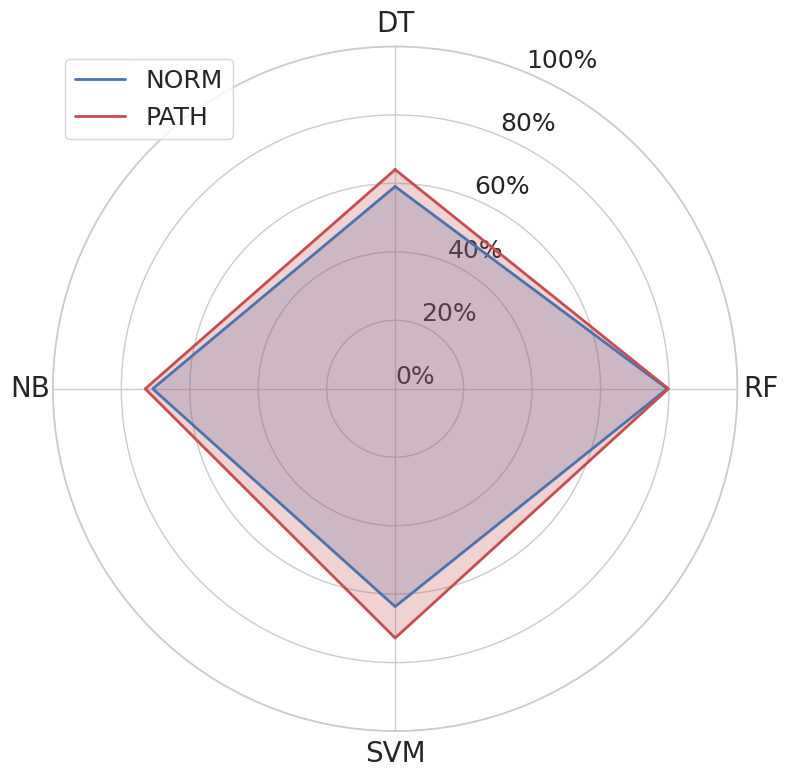

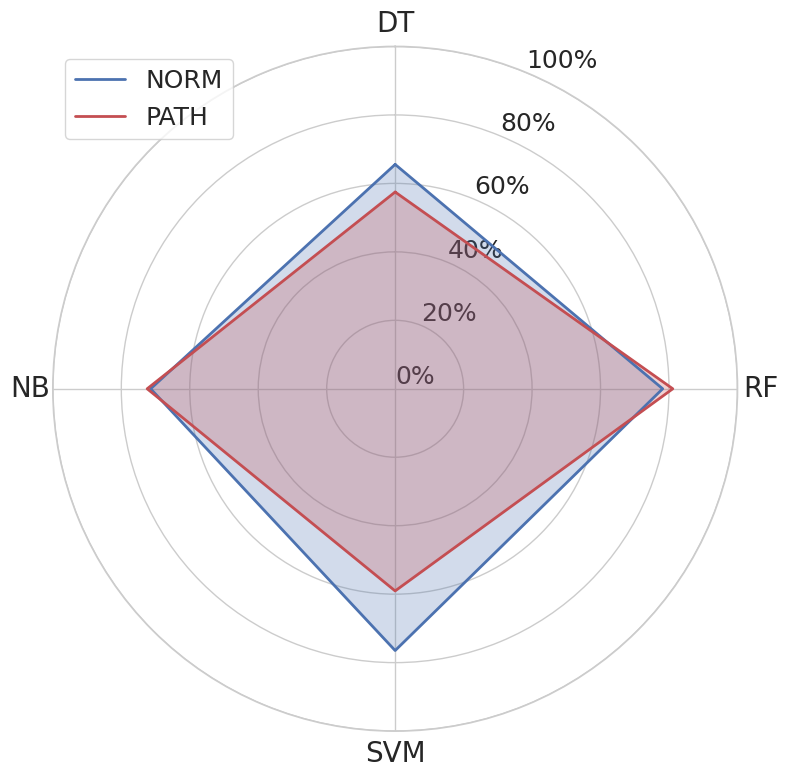

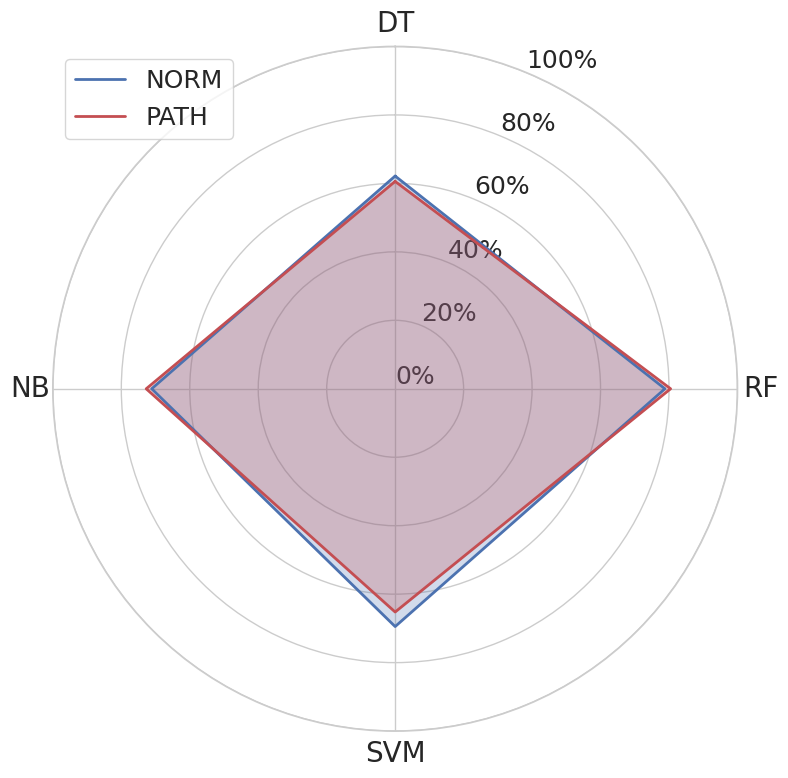

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")

# Assuming you have your data in X_flat and Y, and cv (cross-validation) is defined
# Initialize classifiers
classifiers = {
    'DT': DecisionTreeClassifier(random_state=42),
    'RF': RandomForestClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'NB': GaussianNB()
}

# Initialize StratifiedKFold
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Store performance metrics for radar plots
metrics = {
    'precision_NORM': [],
    'recall_NORM': [],
    'f1_NORM': [],
    'precision_PATH': [],
    'recall_PATH': [],
    'f1_PATH': []
}

# Collect performance metrics for each classifier
for name, clf in classifiers.items():
    print(f"Evaluating {name}...")

    # Cross-validation predictions
    y_pred = cross_val_predict(clf, X_flat, Y, cv=cv)

    # Performance metrics for each class
    precision_NORM = precision_score(Y, y_pred, pos_label=0, average='binary')
    recall_NORM = recall_score(Y, y_pred, pos_label=0, average='binary')
    f1_NORM = f1_score(Y, y_pred, pos_label=0, average='binary')

    precision_PATH = precision_score(Y, y_pred, pos_label=1, average='binary')
    recall_PATH = recall_score(Y, y_pred, pos_label=1, average='binary')
    f1_PATH = f1_score(Y, y_pred, pos_label=1, average='binary')

    # Store metrics for radar plots
    metrics['precision_NORM'].append(precision_NORM)
    metrics['recall_NORM'].append(recall_NORM)
    metrics['f1_NORM'].append(f1_NORM)

    metrics['precision_PATH'].append(precision_PATH)
    metrics['recall_PATH'].append(recall_PATH)
    metrics['f1_PATH'].append(f1_PATH)

    print(f"{name} Performance Metrics for NORM:")
    print(f"Precision: {precision_NORM:.2f}")
    print(f"Recall: {recall_NORM:.2f}")
    print(f"F1 Score: {f1_NORM:.2f}")
    print("-" * 50)
    print(f"{name} Performance Metrics for PATH:")
    print(f"Precision: {precision_PATH:.2f}")
    print(f"Recall: {recall_PATH:.2f}")
    print(f"F1 Score: {f1_PATH:.2f}")
    print("-" * 50)

# Convert metrics dictionary to DataFrame for easier plotting
df_metrics = pd.DataFrame(metrics, index=classifiers.keys())

# Function to create radar plot
def create_radar_plot(data_NORM, data_PATH, categories, title, colors):
    N = len(categories)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]

    values_NORM = data_NORM.tolist()
    values_PATH = data_PATH.tolist()
    values_NORM += values_NORM[:1]
    values_PATH += values_PATH[:1]

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    ax.plot(angles, values_NORM, color=colors[0], linewidth=2, linestyle='solid', label='NORM')
    ax.fill(angles, values_NORM, color=colors[0], alpha=0.25)

    ax.plot(angles, values_PATH, color=colors[1], linewidth=2, linestyle='solid', label='PATH')
    ax.fill(angles, values_PATH, color=colors[1], alpha=0.25)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=20)
    ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels([f"{int(y*100)}%" for y in [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]], fontsize=18)

    ax.legend(loc='upper left', fontsize=18)

    plt.tight_layout()
    plt.show()

# Categories for radar plots
categories = classifiers.keys()
colors = ['b', 'r']  # Colors for NORM and PATH

# Create radar plots
create_radar_plot(df_metrics['precision_NORM'], df_metrics['precision_PATH'], categories, "Precision", colors)
create_radar_plot(df_metrics['recall_NORM'], df_metrics['recall_PATH'], categories, "Recall", colors)
create_radar_plot(df_metrics['f1_NORM'], df_metrics['f1_PATH'], categories, "F1 Score", colors)
